In [1]:
# run it via 5-fold as well
# transfer the STN network from kneeRESv2
# STN looks better with augmentation (test hypothesis)
# in addition to yesterday's conversation.
# Fire weighting or Augment 
    # we can use fire scores to figure out how much to augment (multiplicative factor or something)

In [2]:
from __future__ import print_function
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "5"
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
from six.moves import urllib

torch.manual_seed(0)
plt.ion()  

In [3]:
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

full_dataset = torchvision.datasets.ImageFolder(root = '/data/siddhant/MedicalSTN/DrVineetData/Knee_Full_AP', 
                                     transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Grayscale(num_output_channels=3),
                       transforms.Resize((512,512)),
                   ]))
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

# Training dataset
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=64, shuffle=True, num_workers=2)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=64, shuffle=True, num_workers=2)

outputlen = len(full_dataset.find_classes('/data/siddhant/MedicalSTN/DrVineetData/Knee_Full_AP')[0])

In [4]:
full_dataset.find_classes('/data/siddhant/MedicalSTN/DrVineetData/Knee_Full_AP')

(['Biopro Townley',
  'Depuy AMK',
  'Depuy Coordinate',
  'Depuy New Jersey',
  'Djo Encore Foundation',
  'Exactech Opterak',
  'Howmedia Duracon TS',
  'Howmedia PCA',
  'Impex Continum',
  'Intermedics NK',
  'Osteonics 3000 Series',
  'Smith and Nephew Legion',
  'Smith and Nephew TC Plus solution',
  'Smith and Nephew profix',
  'Smith and Nephew- Journey 1 BCS',
  'Smith and Nephew- Journey 2 BCS',
  'Smith and Nephew- Journey: Journey 2',
  'Stryker Duracon',
  'Stryker NRG',
  'Stryker Scorpio',
  'Wright Medical Advance',
  'Wright Medical Advantim TC CR',
  'Wright Medical Advantim TC PS',
  'Wright Medical Axiom Revision',
  'Zimmer Biomet LPS Flex Knee',
  'Zimmer LPS',
  'Zimmer Nexgen Legacy',
  'Zimmer Persona'],
 {'Biopro Townley': 0,
  'Depuy AMK': 1,
  'Depuy Coordinate': 2,
  'Depuy New Jersey': 3,
  'Djo Encore Foundation': 4,
  'Exactech Opterak': 5,
  'Howmedia Duracon TS': 6,
  'Howmedia PCA': 7,
  'Impex Continum': 8,
  'Intermedics NK': 9,
  'Osteonics 3000 Se

In [5]:
class STNresnet(nn.Module):
    def __init__(self):
        super(STNresnet, self).__init__()
        # Spatial transformer localization-network
        self.finalfc = nn.Linear(1000, outputlen)
        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 124 * 124, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        self.resnetportion = torchvision.models.resnet18(pretrained = False)
    
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(x.shape[0], -1) 
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x
    
    def forward(self, x):
        xs = self.localization(x)
        xs = xs.view(x.shape[0], -1) 
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        x = self.resnetportion(x)
        x = self.finalfc(x)
        return F.log_softmax(x, dim=1), x


In [6]:
class STNnet(nn.Module):
    def __init__(self):
        super(STNnet, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(20 * 125 * 125, 50)
        self.fc2 = nn.Linear(50, outputlen)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 124 * 124, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(x.shape[0], -1) 
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        x = self.stn(x)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1), x

In [7]:
# model = STNnet().to(device)
model = STNresnet().to(device)


In [8]:
def train(epoch):
    model.train()
    for data, target in tqdm(train_loader): 
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output, layer = model(data)
        loss = F.nll_loss(output, target) + torch.sum(torch.square(layer))
        loss.backward()
        optimizer.step()
#         if batch_idx % 5 == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item()))
    

def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        preds = []
        targets = []
        for data, target in tqdm(test_loader):
            data, target = data.to(device), target.to(device)
            output, _ = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            # print(pred)
            correct += pred.eq(target.view_as(pred)).sum().item()
            preds.extend(np.array(pred.cpu()))
            targets.extend(np.array(target.cpu()))
        from sklearn.metrics import confusion_matrix
        conf_mat=confusion_matrix(targets, preds)
        print(conf_mat)
        #TODO make confusion matrix
        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

def train_conf():
    with torch.no_grad():
        model.eval()
        train_loss = 0
        correct = 0
        preds = []
        targets = []
        for data, target in tqdm(train_loader):
            data, target = data.to(device), target.to(device)
            output,_ = model(data)
            # sum up batch loss
            train_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            # print(pred)
            correct += pred.eq(target.view_as(pred)).sum().item()
            preds.extend(np.array(pred.cpu()))
            targets.extend(np.array(target.cpu()))
        from sklearn.metrics import confusion_matrix
        conf_mat=confusion_matrix(targets, preds)
        print(conf_mat)
        train_loss /= len(train_loader.dataset)
        print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(train_loss, correct, len(train_loader.dataset),
                      100. * correct / len(train_loader.dataset)))

In [9]:
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [ ]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp + mean
    # inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()
        print(input_tensor.shape, transformed_input_tensor.shape, max(input_tensor.flatten()), max(transformed_input_tensor.flatten()))
        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

for epoch in range(1, 500 + 1):
    train(epoch)
    train_conf()
    test()

# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[[  0   0   0   0   0   4   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   4   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   5   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   1   0   0   0   4   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   4   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 140   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   5   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   3   0   0   0   0   0   0   0   0   0   

  0%|          | 0/3 [00:00<?, ?it/s]

[[ 0  0  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 27  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  6  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 17  0  0  0  0  0  0  0  0  1  0  1]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 24  0  0  0  0  0  0  5  0  4  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  6  0  0  0  0  0  0  1  0 12  0  3]
 [ 0  1  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 21  0  0  0  0  0  0  1  0  2  0  6]]

Test set: Average loss: 3.3265, Accuracy: 50/150 (33%)



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[[  0   0   0   0   0   0   0   0   3   0   0   0   0   0   0   0   1   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   3   0   0   0   0   0   0   0   1   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   4   0   0   0   0   0   0   0   1   0
    0   0   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0   0   2   0   0   0   0   0   0   0   2   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   4   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 139   0   0   1   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   1   0   0   1   0   0   3   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    1   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   3   0   0   0   0   0   0   

  0%|          | 0/3 [00:00<?, ?it/s]

[[ 0  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  4  0  0  0  0  1  0  0  1  0  0  0  0]
 [ 0  0  0  1  0  5  0  4  0  0  0  0  3  0  0  6  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  5  0  3  0  2  0  0  1  0 21  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  0  0  0  2  0  0 17  0  1]
 [ 0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 14  0  4  0  0  0  0

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   4   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0
    0   3   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   2   0   0   0   0   0   0   0   0   0   0   0   0
    0   3   0   0   0   0   0   0   0   0]
 [  0   1   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0
    0   3   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   4   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 140   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0
    0   4   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

  0%|          | 0/3 [00:00<?, ?it/s]

[[ 0  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0 26  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  4  0  0  0  0  0  0  0  0  2  0  0  0  0]
 [ 0  0  4  0  0  0  5  0  0  1  0  7  0  0  0  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0 12  1  0  0  3  0  0  0  3 13  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  4  0  0  0  1  0  0  0  0  4  0  9  0  4]
 [ 0  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0 13  0  0  0  2  0  0  0  0  8  0  0  0  7]]

Test set: Average loss: 3.3263, Accuracy: 51/150 (34%)



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[[  0   1   0   0   3   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   3   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   5   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   1   0   0   2   0   0   0   0   0   0   0   0   0   0   0   2   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   1   0   0   3   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 138   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   1   0   0   0   0   0   0   1]
 [  0   3   0   0   1   1   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   2   1   0   0   0   0   0   0   0   0   0   

  0%|          | 0/3 [00:00<?, ?it/s]

[[ 0  0  1  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  1  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 27  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  2  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  3  1  0  0  7  0  0  0  1  0  3  0  3]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  1  0  0  7  0  0  4  0  0  0 14  0  7  0  0]
 [ 0  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  2  0  0  0  0  0 17  0  2]
 [ 0  1  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  2 16  0  0  0  0  0  0  1  0  4  0  7]]

Test set: Average loss: 3.3263, Accuracy: 73/150 (49%)



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[[  0   0   0   0   0   3   0   0   0   0   0   0   0   0   0   0   0   1
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   2   1   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   1]
 [  0   0   0   0   0   5   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   5   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   4   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 139   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   1]
 [  0   0   0   0   0   5   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   2   0   0   0   0   0   0   0   0   0   

  0%|          | 0/3 [00:00<?, ?it/s]

[[ 0  0  1  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 27  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  7]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 31  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0  0  0  0  7  0  5]
 [ 0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 18  0  0  0  0  0  0  0  0  0  0  1  0 11]]

Test set: Average loss: 3.3262, Accuracy: 45/150 (30%)



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[[  0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   3]
 [  0   0   0   0   0   0   0   0   3   0   0   1   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   4]
 [  0   0   0   0   0   0   0   0   1   0   0   3   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   1]
 [  0   0   0   0   0   0   0   0   1   0   0   1   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   2]
 [  0   0   0   0   0 127   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0  13]
 [  0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   1   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   1]
 [  0   0   0   0   0   0   0   0   1   0   0   1   0   0   0   

  0%|          | 0/3 [00:00<?, ?it/s]

[[ 0  0  0  0  1  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 26  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  5]
 [ 0  0  0  0  0  0 10  0  0  0  1  0  0  0  8]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  1]
 [ 0  0  2  0  0  0  9  0  0  0 11  0  2  0  9]
 [ 0  0  0  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  5  0  0  0  1  0 10  0  6]
 [ 0  0  0  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  8  0  0  0  2  0  0  0  1  0  1  0 18]]

Test set: Average loss: 3.3264, Accuracy: 75/150 (50%)



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[[  0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
    0   0   0   0   0   0   0   0   0   2]
 [  0   0   1   0   0   1   1   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   1   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   1   0
    0   0   0   0   0   0   0   0   0   3]
 [  0   0   0   0   0   1   0   0   0   0   0   0   1   0   0   0   2   0
    0   0   0   0   0   0   0   0   0   1]
 [  0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0
    0   0   0   0   0   0   0   0   0   2]
 [  0   0   0   0   0 136   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   4]
 [  0   0   0   0   0   3   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   2]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   1]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

  0%|          | 0/3 [00:00<?, ?it/s]

[[ 0  1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 26  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  1  1  0  0  0  0  0  0  1  0  0  0  0  0  3]
 [ 0  0  0  2  0  0  0  0  0  0  0  0  0  1  0  0 16]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  1  0  0  0  0  0]
 [ 0  0  1 12  0  0  0  0  0  0  3  0  2  0  0  0 15]
 [ 0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  3  0  0  0  0  0  0  2  0  0  0  1  0 15]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0 19]]

Test set: Average loss: 3.3264, Accuracy: 50/150 (33%)



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[[ 0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  1  0  0]
 [ 0  0  1  0  0  0  0  0  2  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [ 0  0  1  0  0  0  0  0  1  0  0  2  0  0  0  0  0  0  0  0  1  0  0  0
   0  0  0  0]
 [ 0  0  0  1  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0
   0  1  0  0]
 [ 0  0  1  0  0  0  0  0  2  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [ 0  0  0  0  0 13  0  0 75  0  0  0  0  0  0  0  0  0  0 24  0  0  0  0
   0  3  0 25]
 [ 0  0  0  0  0  0  0  0  3  0  0  1  0  0  0  0  0  0  0  1  0  0  0  0
   0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  1  0  0]
 [ 0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [ 0  0  0  0  0  0  0  0  2  1  0  0  0  0  0  0  0  0  0  0  1  0  0  0
   0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [ 0  0  0  0  0  0  

  0%|          | 0/3 [00:00<?, ?it/s]

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  1  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 15  0  0  0  0  0  0  7  0  0  0  0  5]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  4  0  1  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  1  0 10  0  0  0  0  0  0  0  7  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  4  0 14  0  0  0  2  0  0  0  9  0  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  4  0  0  0  0  0  0  0 17  0  1]
 [ 0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  4  0  2  0  0

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[[  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   3]
 [  0   0   0   0   0   1   0   0   0   0   0   0   1   0   0   0   0   0
    0   0   0   0   0   0   0   0   1   1]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   4]
 [  0   0   0   0   0   0   1   0   0   0   0   0   2   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   2]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   3]
 [  0   0   0   0   0  97   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0  43]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   4]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   1]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0   0   

  0%|          | 0/3 [00:00<?, ?it/s]

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  6]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0 18]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 0  0  0  1  0  1  0  1  0  0  0  0  2  0  0  0 28]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  8  0 14]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  0  0  1  0 27]]

Test set: Average loss: 3.3269, Accuracy: 55/150 (37%)



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[[ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  1  0  2]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   2  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  3  0  2]
 [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0
   0  2  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  2  0  1]
 [ 0  0 42  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  57  2  1 18]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  2  0  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  2  1  0]
 [ 0  1  0  0  0  0  0  0  1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0
   0  0  0  1]
 [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [ 0  0  0  0  0  0  

  0%|          | 0/3 [00:00<?, ?it/s]

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 11  0  0  4  0  0  0  0  0  0  0  0  9  0  0  3]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  4]
 [ 0  0  0  0  0  0  0  3  0  0  0  0  0  0  2 10  0  4]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  1  0  0  0  0  1  0  0  0  1 29  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0 18  0  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  0  0]
 [ 0  0  4  0  0  0  0  1  0  0

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[[  0   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    1   0   0   0   0   0   0   0   0   1]
 [  0   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
    0   0   0   0   0   0   0   0   0   0]
 [  0   2   0   0   0   1   1   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   1]
 [  0   3   0   0   0   0   0   0   0   0   0   0   2   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 135   2   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   3]
 [  0   2   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   2]
 [  0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   2   0   0   0   0   0   0   0   0   0   0   0   0   0   

  0%|          | 0/3 [00:00<?, ?it/s]

[[ 0  1  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0 26  0  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  5  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  1  0  0  0  0  0  0  0  0  1  0  0  0 16]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  2 11  4  0  0  1  0  0  0  0  0  3  0  0  0 12]
 [ 0  1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  1  3  1  0  0  0  0  0  0  0  0  1  0  0  0 16]
 [ 0  1  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  1 11  0  0  0  0  0  1  0  0  0  1  0  0  0 16]]

Test set: Average loss: 3.3257, Accuracy: 47/150 (31%)



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[[  0   0   0   0   0   2   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   1   0   0   0   0   0   1]
 [  0   0   0   0   0   2   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   2   0   0   0]
 [  0   0   0   0   0   3   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   2]
 [  0   1   0   0   0   2   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   1   1   0   0]
 [  0   0   0   0   0   4   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 138   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   2]
 [  0   0   0   0   0   5   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   2   0   0   0   0   0   0   0   0   0   

  0%|          | 0/3 [00:00<?, ?it/s]

[[ 0  0  1  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  2  0  0  0]
 [ 0  0 26  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  5  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  5  0  0  2  0  0  0  0  0  7  0  5]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 18  0  0  2  0  0  0  5  1  6  0  1]
 [ 0  0  1  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  3  0  0  0  0  0  0  0  0 16  0  3]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 16  0  0  0  0  0  0  0  0  4  0 10]]

Test set: Average loss: 3.3261, Accuracy: 59/150 (39%)



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[[  0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   2   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   2]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   5]
 [  0   0   0   0   0   0   3   0   0   0   0   1   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   1]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   3]
 [  0   0   0   0   0 128   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0  12]
 [  0   0   0   0   0   1   1   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   1]
 [  0   0   0   0   0   0   1   0   0   0   0   1   0   0   0   

  0%|          | 0/3 [00:00<?, ?it/s]

[[ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 25  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  5]
 [ 0  0  1  0  0  0  7  0  0  0  0  0  0  0 11]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  4  0  0  0  5  0  0  0  0  0  0  0 24]
 [ 0  0  0  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  7  0  0  0  0  0  0  0 15]
 [ 0  0  0  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  7  0  0  0  1  0  0  0  0  0  0  0 22]]

Test set: Average loss: 3.3256, Accuracy: 54/150 (36%)



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  3  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  4  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  3  0  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  5  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  4  0  0]
 [ 0  0  0  0  0 55  0  0 20  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0
  44  6  0 11]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  5  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  3  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  2  0  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  2  0  0]
 [ 0  0  0  0  0  1  

  0%|          | 0/3 [00:00<?, ?it/s]

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0]
 [ 0  0  7  0  4  0  0  0  0  0  0  0 14  0  0  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 16  0  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  1]
 [ 0  0  1  0  0  0  0  1  0  0  0 12  0 18  0  1]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0 21  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  1  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  2  4  8  0 14]]

Test set: Average loss: 3.3274, Accuracy: 54/150 (36%)



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[[  0   1   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   2]
 [  0   3   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   4]
 [  0   2   0   0   0   0   0   0   0   0   0   1   0   0   2   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   1]
 [  0   0   0   0   0 120   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0  20]
 [  0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   1   0   0   0   0   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   1]
 [  0   3   0   0   0   0   0   0   0   0   0   0   0   0   0   

  0%|          | 0/3 [00:00<?, ?it/s]

[[ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  1  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0 25  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  2  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  5  0  0  0  0  1  0  3  0 10]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  1]
 [ 0  0  1  0  0  2  0  0  0  0  0  0 17  0 13]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0 14  0  7]
 [ 0  1  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  6  0  0  0  0  0  0  0  0  0  2  0 22]]

Test set: Average loss: 3.3258, Accuracy: 68/150 (45%)



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   4   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   3   0   0   0   0
    0   0   0   0   0   0   0   1   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   5   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   5   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   4   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 137   0   0   0   0   0   0   0   1   0   0   0   0
    0   0   0   0   0   0   0   0   0   2]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   5   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   3   0   

  0%|          | 0/3 [00:00<?, ?it/s]

[[ 0  0  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0 26  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  5  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 12  0  0  3  0  0  0  4]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0 10  0  0 20  0  0  0  1]
 [ 0  0  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  8  0  0  2  0 12  0  0]
 [ 0  0  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0 11  0  0  0  6  0  0  2  0  2  0  9]]

Test set: Average loss: 3.3254, Accuracy: 68/150 (45%)



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[[  0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   4   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   2   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   2   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   2   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   2]
 [  0   0   0   0   0 118   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0  22]
 [  0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   4]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   1]
 [  0   0   0   0   0   0   0   0   0   0   3   0   0   0   0   

  0%|          | 0/3 [00:00<?, ?it/s]

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 0  0  0  0  0  2  0  0  0  0  0  0  0  0  0]
 [ 0  0 22  0  0  0  0  0  0  0  0  0  0  0  5]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 19]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0 32]
 [ 0  0  0  0  0  2  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 22]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0 25]]

Test set: Average loss: 3.3278, Accuracy: 47/150 (31%)



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   1   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0
    0   0   0   0   0   0   0   1   1   1]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   1   0   4]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   1   1   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   4]
 [  0   0   0   0   0 129   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0  11]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   1   0   4]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   1   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

  0%|          | 0/3 [00:00<?, ?it/s]

[[ 0  0  0  0  0  0  0  0  0  0  0  0  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  1  0]
 [ 0  0 24  0  0  0  0  0  0  0  0  0  0  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  7  0 12]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 0  0  1  0  0  0  0  0  0  1  0 27  0  4]
 [ 0  0  0  0  0  0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 15  0  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  1  0]
 [ 0  0  6  0  0  0  0  0  0  0  0  4  0 20]]

Test set: Average loss: 3.3258, Accuracy: 61/150 (41%)



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[[  0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   3]
 [  0   0   0   0   0   4   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   3   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   2]
 [  0   0   0   1   0   2   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   2]
 [  0   0   0   0   0   2   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   2]
 [  0   0   0   0   0 137   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   3]
 [  0   0   0   0   0   2   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   3]
 [  0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   2   0   0   1   0   0   0   0   0   0   

  0%|          | 0/3 [00:00<?, ?it/s]

[[ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 26  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 0  0  0  1  0  0  0  0  0  0  0  1  0  0  0 17]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  8  0  0  0  0  0  0  5  0  0  0  0 20]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  4  0  0  0  0  0  0  0  0  0  0  0 17]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0 14  0  0  0  0  0  0  0  0  0  0  0 16]]

Test set: Average loss: 3.3272, Accuracy: 47/150 (31%)



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[[  0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   3]
 [  0   0   1   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0
    1   0   0   1   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    1   0   0   2   0   0   0   0   0   2]
 [  0   0   0   1   0   1   0   0   0   0   0   0   0   0   0   0   1   0
    0   0   0   1   0   0   0   0   0   1]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   4   0   0   0   0   0   0]
 [  0   0   0   0   0 137   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    1   0   0   3   0   0   0   0   0   1]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    1   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   

  0%|          | 0/3 [00:00<?, ?it/s]

[[ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 26  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 12  0  0  0  0  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  1  1  0  0  0  0  0  0  0 30  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 15  0  0  1  0  6]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0 11  0  0  0  0  0

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  2  0
   0  0  0  1]
 [ 0  0  0  0  0  0  0  0  1  0  0  1  0  0  0  0  0  0  0  2  0  0  0  0
   0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0
   0  0  0  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  1  0
   0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0
   0  0  0  1]
 [ 0  0  0  0  0 53  0  0 74  0  0  0  0  0  0  0  0  0  0  1  2  0  0  0
   0  0  0 10]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0
   0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
   0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0
   0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  1  0  0  0  0  0  0  0  2  0  0  0  0
   0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  1  0  0  0  0
   0  0  0  0]
 [ 0  0  0  0  0  0  

  0%|          | 0/3 [00:00<?, ?it/s]

[[ 0  0  0  0  1  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  8  0 16  0  0  0  0  0  0  1  1  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  0  0  0  0  2  0  0  0  0  0  1]
 [ 0  0  0  0  0  0 13  0  0  0  0  1  0  1  0  1  0  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  7  0  0  0 11  5  1  1  0  3  0  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  6  0  0  0  1  1  0  0  0 10  0  4]
 [ 0  0  0  0  1  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  3  0  3  0  4  0  0  0

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[[  0   0   0   2   0   2   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   1   0   1   0   0   0   0   0   0   0   0   0   0   0   1
    1   0   0   0   0   0   0   0   0   0]
 [  0   0   0   1   0   1   0   0   0   0   0   0   0   0   0   0   1   0
    1   0   0   0   0   0   0   0   0   1]
 [  0   0   0   2   0   0   0   0   0   0   1   0   0   0   0   0   1   1
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   4   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 137   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   3]
 [  0   0   0   2   0   2   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   1]
 [  0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   2   0   0   0   0   0   0   1   0   0   0   0   

  0%|          | 0/3 [00:00<?, ?it/s]

[[ 0  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  2  0  0  0  0  0  0  2  2  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  2  0  0  0  0  0  0  4  0  6  1  0  1  0  4]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  1  0  0  0  0  0  0]
 [ 0  0  1  4  0  0  0  0  0  0  0  0 27  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  1  0  0  0  0  0  0  0  1  5  0  0 12  0  2]
 [ 0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  9  0  0  1  0  0  0

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[[  0   0   0   0   0   1   0   0   1   0   0   0   0   0   0   0   0   0
    0   1   0   0   0   1   0   0   0   0]
 [  0   0   0   0   0   1   0   0   1   0   0   1   0   0   0   0   0   0
    0   1   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   1   0   0   1   0   0   0   0   0   0
    0   2   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   2   0   0   1   0   0   0   0   0   0   0   0   0
    0   0   1   0   0   1   0   0   0   0]
 [  0   0   0   0   0   1   0   0   1   0   0   0   0   0   0   0   0   0
    0   2   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 138   0   0   0   0   0   0   0   0   0   0   0   0
    0   2   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   2   0   0   1   0   0   0   0   0   0   0   0   0
    0   2   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   1   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

  0%|          | 0/3 [00:00<?, ?it/s]

[[ 0  0  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 26  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  1  0  1  0  0  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  1  0  1  0 15  0  0  0  0  0  1  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  4  0  1  0  9  0  0  0 15  4  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  2  0  0  0 13  0  0  0  1  0

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[[  0   0   0   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   2]
 [  0   0   0   3   0   1   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    1   0   0   0   0   0   0   0   0   3]
 [  0   0   0   3   0   1   0   0   0   0   0   0   0   0   0   0   0   0
    1   0   0   0   0   0   0   0   0   0]
 [  0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   3]
 [  0   0   0   0   0 122   0   0   0   0   0   0   0   0   0   0   0   0
    0   3   0   0   0   0   0   0   0  15]
 [  0   0   0   2   0   0   0   0   1   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   2]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   1]
 [  0   0   0   3   0   0   0   0   0   0   0   0   0   0   0   

  0%|          | 0/3 [00:00<?, ?it/s]

[[ 0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 25  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  6]
 [ 0  0  0  0  0  0  0  0  0  0  5  0  0  2  0 12]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  1  1  0  0  0  0  0  0 23  0  0  0  0  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  4  0  0 10  0  7]
 [ 0  0  0  0  0  0  0  0  0  0  1  1  0  0  0  0]
 [ 0  0  0  5  0  0  0  0  0  0  4  0  0  1  0 20]]

Test set: Average loss: 3.3268, Accuracy: 78/150 (52%)



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[[  0   0   0   0   0   2   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   2   0   0]
 [  0   0   0   0   0   2   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   2   0   0]
 [  0   0   0   0   0   4   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   1   0   0]
 [  0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   4   0   0]
 [  0   0   0   0   0   4   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 140   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   4   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   1   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   1   0   1   0   0   0   0   0   0   0   0   0   

  0%|          | 0/3 [00:00<?, ?it/s]

[[ 0  0  1  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0 27  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  5  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  4  0  0  0  0  0  0  1  0 14  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  9  0  0  0  0  0  0 13  0 11  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  2  0 20  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0 15  0  0  0  0  0  0  1  0 12  0  2]]

Test set: Average loss: 3.3267, Accuracy: 62/150 (41%)



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[[  0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   3]
 [  0   0   0   0   0   0   0   0   0   1   0   0   0   0   1   0   0   0
    0   0   0   0   0   0   0   0   0   2]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   5]
 [  0   0   0   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   4]
 [  0   0   0   0   0  55   0   0   0   0   0   0   0   0   1   0   0   0
    0   1  71   0   0   0   0   0   0  12]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   1   0   0   0   0   0   0   0   4]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   1]
 [  0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   

  0%|          | 0/3 [00:00<?, ?it/s]

[[ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  1]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0  0  0  1 14  0  0  0  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  6]
 [ 0  0  0  0  0  0  0  1  0  1  0  0  0  0  0  0  0 17]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  2  0  6  0  0  0  0  0 25]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  1  0  1  0  0  0  2  0 17]
 [ 0  0  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  3  1  0  0  0  0  0

  0%|          | 0/10 [00:00<?, ?it/s]

In [12]:
path = '/home/siddhant/data/MedicalSTN/models/stnresnetfulllcnn/'
import os
if not os.path.exists(path):
    os.makedirs(path)
torch.save(model.state_dict(), f'{path}/statedict.pt')
torch.save(model, f'{path}/model.pt')
torch.save(optimizer, f'{path}/optimizer.pt')
state = {
    'epoch': epoch,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}
torch.save(state, f'{path}/statedict_full.pt')

In [13]:
with torch.no_grad():
    model.eval()
    test_loss = 0
    correct = 0
    preds = []
    targets = []
    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        output,_ = model(data)

        # sum up batch loss
        test_loss += F.nll_loss(output, target, size_average=False).item()
        # get the index of the max log-probability
        pred = output.max(1, keepdim=True)[1]
        # print(pred)
        correct += pred.eq(target.view_as(pred)).sum().item()
        preds.extend(np.array(pred.cpu()))
        targets.extend(np.array(target.cpu()))
    from sklearn.metrics import confusion_matrix
    conf_mat=confusion_matrix(targets, preds)
    a = conf_mat
    #TODO make confusion matrix
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
          .format(test_loss, correct, len(test_loader.dataset),
                  100. * correct / len(test_loader.dataset)))
for i in range(len(a[0])):
    print(a[i][i], np.sum(a[i]))
with torch.no_grad():
    model.eval()
    train_loss = 0
    correct = 0
    preds = []
    targets = []
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)
        output,_ = model(data)
        # sum up batch loss
        train_loss += F.nll_loss(output, target, size_average=False).item()
        # get the index of the max log-probability
        pred = output.max(1, keepdim=True)[1]
        # print(pred)
        correct += pred.eq(target.view_as(pred)).sum().item()
        preds.extend(np.array(pred.cpu()))
        targets.extend(np.array(target.cpu()))
    from sklearn.metrics import confusion_matrix
    conf_mat=confusion_matrix(targets, preds)
    a = conf_mat
    train_loss /= len(train_loader.dataset)
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
          .format(train_loss, correct, len(train_loader.dataset),
                  100. * correct / len(train_loader.dataset)))
for i in range(len(a[0])):
    print(a[i][i], np.sum(a[i]))

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 3.3265, Accuracy: 66/150 (44%)

0 2
0 2
0 0
26 27
0 1
0 0
0 6
0 19
0 1
0 1
0 2
5 33
0 0
0 0
0 2
17 22
0 2
18 30


  0%|          | 0/10 [00:00<?, ?it/s]


Train set: Average loss: 3.3256, Accuracy: 280/597 (47%)

0 4
0 4
0 5
0 5
0 4
130 140
0 5
0 1
0 3
0 4
0 2
1 84
0 4
0 2
0 1
0 2
0 7
1 17
5 68
0 3
1 3
0 3
0 2
0 2
1 2
58 78
0 3
83 139


torch.Size([64, 3, 512, 512]) torch.Size([64, 3, 512, 512]) tensor(0.9999) tensor(0.9999)


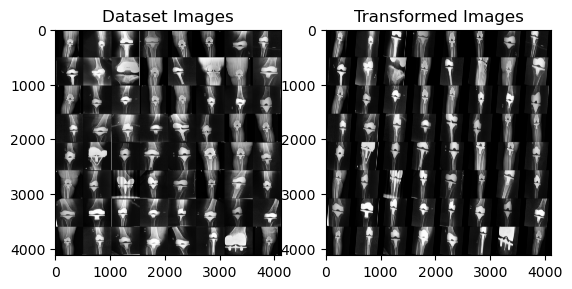

In [14]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp + mean
    # inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()
        print(input_tensor.shape, transformed_input_tensor.shape, max(input_tensor.flatten()), max(transformed_input_tensor.flatten()))
        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

visualize_stn()

In [ ]:
with torch.no_grad():
    model.eval()
    test_loss = 0
    correct = 0
    preds = []
    targets = []
    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)

        # sum up batch loss
        test_loss += F.nll_loss(output, target, size_average=False).item()
        # get the index of the max log-probability
        pred = output.max(1, keepdim=True)[1]
        # print(pred)
        correct += pred.eq(target.view_as(pred)).sum().item()
        preds.extend(np.array(pred.cpu()))
        targets.extend(np.array(target.cpu()))
    from sklearn.metrics import confusion_matrix
    conf_mat=confusion_matrix(targets, preds)
    a = conf_mat
    #TODO make confusion matrix
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
          .format(test_loss, correct, len(test_loader.dataset),
                  100. * correct / len(test_loader.dataset)))
for i in range(len(a[0])):
    print(a[i][i], np.sum(a[i]))
with torch.no_grad():
    model.eval()
    train_loss = 0
    correct = 0
    preds = []
    targets = []
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        # sum up batch loss
        train_loss += F.nll_loss(output, target, size_average=False).item()
        # get the index of the max log-probability
        pred = output.max(1, keepdim=True)[1]
        # print(pred)
        correct += pred.eq(target.view_as(pred)).sum().item()
        preds.extend(np.array(pred.cpu()))
        targets.extend(np.array(target.cpu()))
    from sklearn.metrics import confusion_matrix
    conf_mat=confusion_matrix(targets, preds)
    a = conf_mat
    train_loss /= len(train_loader.dataset)
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
          .format(train_loss, correct, len(train_loader.dataset),
                  100. * correct / len(train_loader.dataset)))
for i in range(len(a[0])):
    print(a[i][i], np.sum(a[i]))